# 第十一週：Text Presentation
本周課程為「Text Presentation」，主要會使用到gensim套件來實現自行訓練word2vec模型以及使用預訓練word2vec模型，以及透過sentence-transformers以及API取得embeddings。


### 大綱：
1.   DEMO
*   Word2Vec
  *   自己訓練w2v模型
  *   使用別人訓練好的w2v模型
*   Transformers Embeddings
  *   小模型（BERT）：
      *   不同語言的BERT：uncased / chinese / multilingual
  *   大模型（LLM）：
      *   API based
      *   Open Source LLM  

2.   資料集實作任務
*    使用embedding 做 NLP 任務
  *   找相似文件（文章）
  *   文件分類任務


### 套件安裝

連接雲端資料夾

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

# os.chdir('content/drive/My Drive') #切換該目錄
# os.listdir() #確認目錄內容

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/研究所/SMA/week11') #切換該目錄
os.listdir() #確認目錄內容

['NLP_DL.ipynb',
 'TaipeiSansTCBeta-Regular.ttf',
 'raw_data',
 'dict',
 'classification_with_embeddings.ipynb',
 'my_NLP_DL.ipynb']

In [ ]:
!pip install scikit-learn-extra
!pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch
sns.set_style("darkgrid")


### 資料前處理

讀入政治版資料集

In [ ]:
# 設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

# 新增stopwords
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    # 自定義詞彙
    custom_words = ["韓國瑜", "民眾黨", "國民黨", "民進黨", "柯文哲", "徐巧芯", "蔡英文", "立法院長", "黃國昌", "黃郁芬", "蔣萬安"]  # 加入你想要的詞彙
    for word in custom_words:
        if word not in seg_list:
            seg_list.append(word)

    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙



    return seg_list

In [ ]:
# 讀入中文示範資料集
origin_data = pd.read_csv('./raw_data/東森政治_34.csv')

In [ ]:
# 資料前處理

# 去除一些不需要的欄位
metaData = origin_data.drop(['artCatagory', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData

Building prefix dict from /content/drive/MyDrive/研究所/SMA/week11/dict/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/研究所/SMA/week11/dict/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u7b80434c55c4ce50f5179103604f7102.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u7b80434c55c4ce50f5179103604f7102.cache
Loading model cost 6.607 seconds.
DEBUG:jieba:Loading model cost 6.607 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,system_id,artTitle,artUrl,artDate,artContent,sentence,word
0,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,新竹縣長楊文科被控涉嫌貪汙,"[新竹, 縣長, 文科, 被控, 涉嫌, 貪汙, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯..."
1,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,昨天日被檢方搜索辦公室且傳喚到案,"[昨天, 檢方, 搜索, 辦公室, 傳喚, 到案, 韓國瑜, 民眾黨, 國民黨, 民進黨, ..."
2,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,檢察官認定他涉有貪污治罪條例的罪嫌重大,"[檢察官, 認定, 他涉, 貪污, 治罪, 條例, 罪嫌, 韓國瑜, 民眾黨, 國民黨, 民..."
3,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,訊後以萬元交保,"[訊後以, 萬元, 交保, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲, 徐巧芯, 蔡英..."
4,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,根據了解,"[韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲, 徐巧芯, 蔡英文, 立法院長, 黃國昌,..."
...,...,...,...,...,...,...,...
12380,282,關切520？AIT主席晉見賴清德 提「維持現狀、兩岸和平」｜東森新聞,https://news.ebc.net.tw/news/article/413096,2024-04-01 22:55:00,美國在台協會主席「羅森柏格」，上任一年多以來五度訪台，在見準總統賴清德的過程中，不斷提到「兩...,他個人信念的推動,"[信念, 推動, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲, 徐巧芯, 蔡英文, 立法..."
12381,282,關切520？AIT主席晉見賴清德 提「維持現狀、兩岸和平」｜東森新聞,https://news.ebc.net.tw/news/article/413096,2024-04-01 22:55:00,美國在台協會主席「羅森柏格」，上任一年多以來五度訪台，在見準總統賴清德的過程中，不斷提到「兩...,馬英九和習近平的這場會面,"[馬英九, 習近平, 這場, 會面, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲, 徐巧..."
12382,282,關切520？AIT主席晉見賴清德 提「維持現狀、兩岸和平」｜東森新聞,https://news.ebc.net.tw/news/article/413096,2024-04-01 22:55:00,美國在台協會主席「羅森柏格」，上任一年多以來五度訪台，在見準總統賴清德的過程中，不斷提到「兩...,是否能夠有別於過去保有一中各表立場,"[有別於, 保有, 一中, 各表, 立場, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲,..."
12383,282,關切520？AIT主席晉見賴清德 提「維持現狀、兩岸和平」｜東森新聞,https://news.ebc.net.tw/news/article/413096,2024-04-01 22:55:00,美國在台協會主席「羅森柏格」，上任一年多以來五度訪台，在見準總統賴清德的過程中，不斷提到「兩...,各種舉動都牽動著美中台關係,"[舉動, 牽動, 著美, 中台, 關係, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲, ..."


### word2vec


####（1）如何自己訓練word2vec模型

建立訓練資料時將考慮bigram，以下為Phrases函式的使用示範

In [ ]:
docs = ['new york is united states', 'new york is most populated city in the world','i love to stay in new york']

token_ = [doc.split(" ") for doc in docs]
# Phrases 建立bigram,
# 少於min_count的字的字或bigrams會被忽略,
# 大於threshold的bigrams會被加入
bigram = Phrases(token_, min_count=1, threshold=2)
bigram_phraser = Phraser(bigram)

for sent in token_:
    print(sent)  #處理前
    print("=> ",bigram_phraser[sent]) # 處理後，還是原本的句子，只是有抓出的bigram片語會被合併

['new', 'york', 'is', 'united', 'states']
=>  ['new_york', 'is', 'united', 'states']
['new', 'york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
=>  ['new_york', 'is', 'most', 'populated', 'city', 'in', 'the', 'world']
['i', 'love', 'to', 'stay', 'in', 'new', 'york']
=>  ['i', 'love', 'to', 'stay', 'in', 'new_york']


實際應用在資料集上

In [ ]:
sents = metaData['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData.head()

,system_id,artTitle,artUrl,artDate,artContent,sentence,word,word_list_bigrams
0,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,新竹縣長楊文科被控涉嫌貪汙,"[新竹, 縣長, 文科, 被控, 涉嫌, 貪汙, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯...","[新竹, 縣長, 文科, 被控, 涉嫌, 貪汙, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯..."
1,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,昨天日被檢方搜索辦公室且傳喚到案,"[昨天, 檢方, 搜索, 辦公室, 傳喚, 到案, 韓國瑜, 民眾黨, 國民黨, 民進黨, ...","[昨天, 檢方, 搜索, 辦公室, 傳喚, 到案, 韓國瑜, 民眾黨, 國民黨, 民進黨, ..."
2,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,檢察官認定他涉有貪污治罪條例的罪嫌重大,"[檢察官, 認定, 他涉, 貪污, 治罪, 條例, 罪嫌, 韓國瑜, 民眾黨, 國民黨, 民...","[檢察官, 認定, 他涉, 貪污_治罪, 條例, 罪嫌, 韓國瑜, 民眾黨, 國民黨, 民進..."
3,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,訊後以萬元交保,"[訊後以, 萬元, 交保, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲, 徐巧芯, 蔡英...","[訊後以, 萬元, 交保, 韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲, 徐巧芯, 蔡英..."
4,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,https://news.ebc.net.tw/news/article/407767,2024-03-01 07:21:00,新竹縣長楊文科被控涉嫌貪汙，昨天（29日）被檢方搜索辦公室且傳喚到案，檢察官認定他涉有貪污治...,根據了解,"[韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲, 徐巧芯, 蔡英文, 立法院長, 黃國昌,...","[韓國瑜, 民眾黨, 國民黨, 民進黨, 柯文哲, 徐巧芯, 蔡英文, 立法院長, 黃國昌,..."


In [ ]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [ ]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 11289


['國民黨', '民進黨', '韓國瑜', '民眾黨', '柯文哲', '徐巧芯', '蔡英文', '立法院長', '黃國昌', '黃郁芬']

In [ ]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 12385
average length of sentences: 14.199031085991118


Word2Vec 計算

In [ ]:
# 環境變數設定
%env PYTHONHASHSEED=8787

env: PYTHONHASHSEED=8787


In [ ]:
# 查看機器的core
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 2


In [ ]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     #  negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

查看結果

In [ ]:
# 檢查最相關的字
w2v_model.wv.most_similar('中國',topn=10)

[('指出', 0.9907572865486145),
 ('台灣', 0.9896187782287598),
 ('調查', 0.9854331612586975),
 ('電價', 0.9849993586540222),
 ('政治', 0.9843461513519287),
 ('對此', 0.9838190078735352),
 ('時間', 0.9828932881355286),
 ('真的', 0.9806481599807739),
 ('事情', 0.9798364043235779),
 ('黃國', 0.9796710014343262)]

In [ ]:
w2v_model.wv.most_similar('台灣',topn=10)

[('政治', 0.9921000003814697),
 ('中國', 0.9896187782287598),
 ('時間', 0.9893283247947693),
 ('質疑', 0.9883819222450256),
 ('電價', 0.9874891042709351),
 ('過程', 0.9874817132949829),
 ('緊張', 0.9872870445251465),
 ('廠商', 0.9861049056053162),
 ('持續', 0.9859579801559448),
 ('事情', 0.9859054684638977)]

In [ ]:
w2v_model.wv.most_similar(['中國','台灣'],topn=10)

[('政治', 0.9907978177070618),
 ('電價', 0.9888138175010681),
 ('時間', 0.9886800646781921),
 ('指出', 0.9874277114868164),
 ('調查', 0.9868000745773315),
 ('對此', 0.9856603145599365),
 ('事情', 0.9854316711425781),
 ('質疑', 0.9852043390274048),
 ('緊張', 0.9845700263977051),
 ('過程', 0.9843201637268066)]

In [ ]:
# 跟兩個字最不相關
w2v_model.wv.most_similar(negative=['中國','台灣'],topn=10)

[('市長', -0.35769155621528625),
 ('韓國瑜', -0.36440181732177734),
 ('萬安', -0.4191249907016754),
 ('台北', -0.45600104331970215),
 ('民眾黨', -0.4653489887714386),
 ('院長', -0.48133817315101624),
 ('國民黨', -0.5113682746887207),
 ('黃國昌', -0.5130202770233154),
 ('立法院長', -0.5214779376983643),
 ('蔡英文', -0.5227984189987183)]

In [ ]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("中國","台灣")

0.9896188

In [ ]:
w2v_model.wv.similarity("國民黨","民進黨")

0.17437348

In [ ]:
# 比較字詞間，誰最不相關（邊緣）
w2v_model.wv.doesnt_match(["國民黨", "民進黨", "民眾"])

'民進黨'

In [ ]:
# 相對關係
w2v_model.wv.most_similar(positive=["國民黨"], negative=["民眾"], topn=5)

[('蔣萬安', 0.2335602194070816),
 ('黃郁芬', 0.18398450314998627),
 ('黃國昌', 0.16964243352413177),
 ('立法院長', 0.13723430037498474),
 ('蔡英文', 0.1294403225183487)]

In [ ]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

視覺化字之間的關係及將字做分群

In [ ]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 25,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat


In [ ]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)


In [ ]:
getVecs(w2v_model,['中國','台灣'])

array([[ 0.09480713,  0.04811194,  0.03284797,  0.20075282,  0.17160384,
         0.02252122,  0.10253593, -0.0505163 ,  0.05298556, -0.01378223,
         0.03694853, -0.1439624 , -0.12463004,  0.03311053, -0.11984347,
         0.1682923 ,  0.18847457,  0.04302615,  0.08216213,  0.04564922,
        -0.06605223,  0.09708114,  0.00269032,  0.14584373, -0.09125116,
         0.08472584,  0.03066029,  0.2575852 ,  0.07608766, -0.15134224,
         0.09809445,  0.0036071 , -0.01254804,  0.0829732 ,  0.01172839,
         0.02013481,  0.0630076 , -0.18953153, -0.21252118, -0.0519365 ,
        -0.02259674, -0.05541398, -0.04188993,  0.07128581, -0.15005092,
         0.0029755 ,  0.0112124 ,  0.0495312 ,  0.08762185, -0.04833069,
         0.12073079, -0.02538803, -0.0485825 , -0.0228605 , -0.08837246,
        -0.02617426, -0.11114559,  0.05183001, -0.18288146, -0.04670399,
        -0.05835869,  0.09994211,  0.02529978,  0.01090046, -0.07182311,
        -0.1315407 , -0.04509389, -0.02435273,  0.0

In [ ]:
# 擴展相似的字詞
def expandPosWord(model,words:list,top_n:int,split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])
    return list(set(expand))


In [ ]:
expandPosWord(w2v_model,['中國','台灣'],top_n = 10)

['時間',
 '中國',
 '事情',
 '緊張',
 '持續',
 '電價',
 '廠商',
 '黃國',
 '過程',
 '政治',
 '質疑',
 '指出',
 '調查',
 '真的',
 '對此',
 '台灣']

In [ ]:
from matplotlib.font_manager import fontManager
import plotly.express as px
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()
# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [ ]:
print(len(words))

176


In [ ]:
sample_words = np.random.choice(list(words),150,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(150, 128)
(150, 2)


In [ ]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

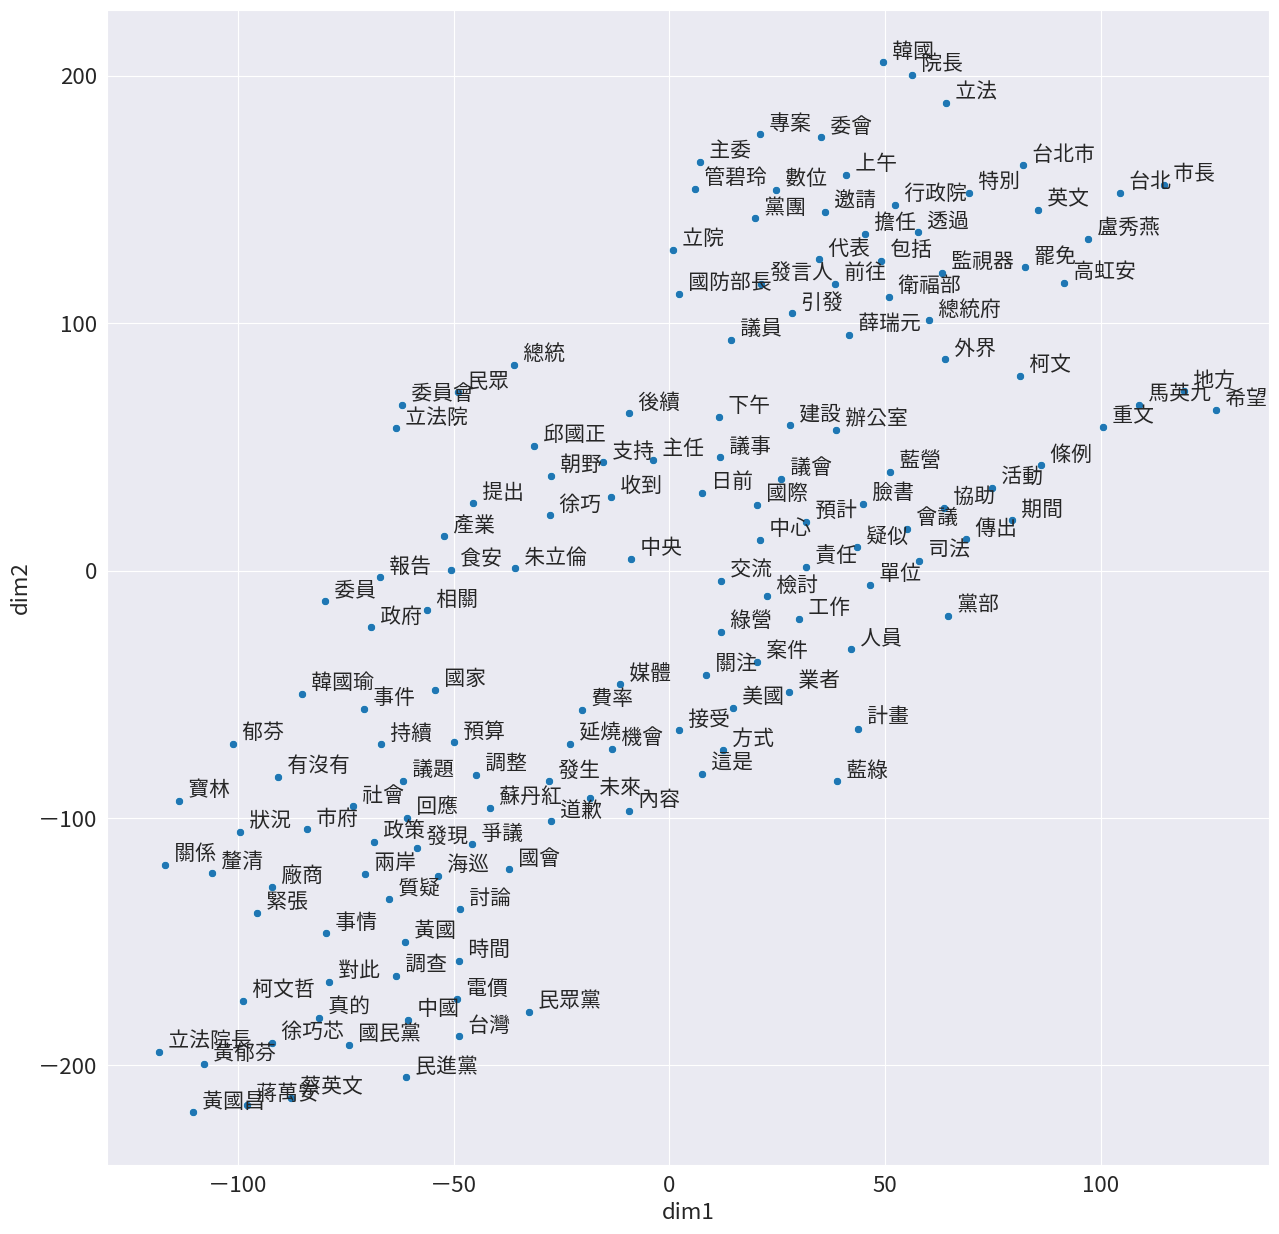

In [ ]:
plotScatter(word_df)

可以看到上圖分類出來的結果不錯，同類型的詞會在附近，像是:<font color="red">
(國民黨 民進黨 民眾黨)
(立法 院長)
(蘇丹紅 道歉)
(預算 調整)
(柯文哲 徐巧芯 蔣萬安 蔡英文 黃國昌 黃郁芬)</font>

3D 散狀圖

In [ ]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(150, 3)


三維空間下，可以更清楚字之間的距離(關係)，但<font color="red">我們的結果詞有一堆都很相近，集中在一起。</font>

將字分群

In [ ]:
!pip install scikit-learn-extra

In [ ]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result


In [ ]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



用顏色去區分，可以更一目了然。<br>
但我們的資料有一坨集中在一起，基本上使用顏色去區分的效果就沒那麼顯著。

### Transformers Embeddings

#### 使用 Sentence-Transformer 套件   
參考資料：https://www.sbert.net/index.html

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 2.0 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, models, util

中文 bert-base-chinese

In [ ]:
# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

### 使用embedding做NLP任務

#### 相似文件

In [ ]:
df_similar = origin_data[['system_id','artTitle', 'artContent']]
df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

df_similar.head(5)

<ipython-input-16-ba0ea2bb5f29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_similar['artContent'] = df_similar['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


,system_id,artTitle,artContent
0,1,新／新竹縣長楊文科涉貪訊後50萬交保 傳與天坑案有關｜東森新聞,新竹縣長楊文科被控涉嫌貪汙昨天日被檢方搜索辦公室且傳喚到案檢察官認定他涉有貪污治罪條例的罪嫌...
1,2,衛星公會提三大訴求 呼籲尊重媒體專業自主｜東森新聞,中華民國衛星廣播商業事業同業公會針對總統與立委大選結束將展開政治新局部分委員即將屆期改任之際...
2,3,馬治薇涉受中國資助百萬選立委 桃檢偵結起訴｜東森新聞,前桃園市立委候選人馬治薇涉收受中國資助參選桃園地檢署今天偵結起訴審酌她犯後態度不佳收受逾新台...
3,4,駁國台辦「冷血說」 管碧玲摸記者臉：看看我的體溫｜東森新聞,海委會主委管碧玲伸出手輕撫記者的臉冷暖要人親自感受這動作就為回應國台辦指控的冷血說但中國漁船...
4,5,民眾黨搶嘸召委！白被爆想叫NCC每月備詢 綠狂批：博聲量｜東森新聞,柯主席這個感冒可讓全黨上下似乎都有相同症狀傳出黨內林國成如果當召委可要每月排程請來立院專案報...


In [ ]:
corpus_embeddings = bert_ch.encode(df_similar['artContent'], convert_to_tensor=True)

query_num = 6 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 駁國台辦「冷血說」 管碧玲摸記者臉：你看看我的體溫｜東森新聞

 資料集中前五相似的文章:
駁國台辦「冷血說」 管碧玲摸記者臉：你看看我的體溫｜東森新聞 (Score: 1.0000)
管碧玲專報改名導「抗中保台」風向？藍委：模糊焦點｜東森新聞 (Score: 0.9846)
駁國台辦「冷血說」 管碧玲摸記者臉：看看我的體溫｜東森新聞 (Score: 0.9801)
特勤少將激吻已婚馬尾妹 國防部諾：釐清真相｜東森新聞 (Score: 0.9801)
拜會侯友宜閉門談「社子島開發」 林右昌不回「政治布局」｜東森新聞 (Score: 0.9791)






In [ ]:
query_num = 30

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 朝野吵翻！管碧玲擅改專報名稱 藍委嗆：不尊重｜東森新聞

 資料集中前五相似的文章:
朝野吵翻！管碧玲擅改專報名稱 藍委嗆：不尊重｜東森新聞 (Score: 1.0000)
管碧玲不接受「撞船」槓高金 海巡署扛責「願承受指責」｜東森新聞 (Score: 0.9880)
管碧玲專報改名導「抗中保台」風向？藍委：模糊焦點｜東森新聞 (Score: 0.9878)
中國漁船翻覆管碧玲明立院專報 綠「甲動」防藍大動作｜東森新聞 (Score: 0.9857)
藍猛打管碧玲！黃捷力挺 徐巧芯諷淪綠「橡皮圖章」｜東森新聞 (Score: 0.9850)






In [ ]:
query_num = 100

query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: 賴清德國安團隊延續「英路線」？傳顧立雄留任機會大｜東森新聞

 資料集中前五相似的文章:
賴清德國安團隊延續「英路線」？傳顧立雄留任機會大｜東森新聞 (Score: 1.0000)
邱國正為兒請辭「被慰留」爆陰謀論？ 藍綠齊挺「堅守崗位」｜東森新聞 (Score: 0.9851)
延續蔡英文路線？傳賴清德盼留任邱太三、黃重諺｜東森新聞 (Score: 0.9847)
喊話想見「老朋友」睽違八年「馬習會」有望再登場｜東森新聞 (Score: 0.9839)
賴就職國宴訂「台南」 新閣揆人選林佳龍、卓榮泰呼聲高｜東森新聞 (Score: 0.9834)




